# Семинар 5: Линейная регрессия, временные признаки и регуляризация

## Подготовка и загрузка данных


In [1]:
%matplotlib inline

In [2]:
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh import extract_features

In [7]:
DATA_PATH = "./jena_climate_2009_2016.csv"

In [8]:
columns = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)", "rh (%)",
               "VPmax (mbar)", "VPact (mbar)",
               "VPdef (mbar)", "sh (g/kg)",
               "H2OC (mmol/mol)", "rho (g/m**3)",
               "wv (m/s)", "max. wv (m/s)", "wd (deg)"]

In [9]:
def load_jena(path: str) -> pd.DataFrame:
    """
    Пытается загрузить датасет Jena Climate из CSV.
    """
    columns = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)", "rh (%)",
               "VPmax (mbar)", "VPact (mbar)",
               "VPdef (mbar)", "sh (g/kg)",
               "H2OC (mmol/mol)", "rho (g/m**3)",
               "wv (m/s)", "max. wv (m/s)", "wd (deg)"]
    
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Убедимся, что все ожидаемые столбцы присутствуют
        missing_cols = [c for c in columns if c not in df.columns]
        if missing_cols:
            raise ValueError(f"В файле отсутствуют ожидаемые столбцы: {missing_cols}")

    # Преобразование времени и индекса
    df["Date Time"] = pd.to_datetime(df["Date Time"], format='%d.%m.%Y %H:%M:%S')
    # df["Date Time"] = pd.to_datetime(df["Date Time"])
    df = df.sort_values("Date Time").set_index("Date Time")
    # df = df.sort_values("Date Time")
    return df

In [10]:
df = load_jena(DATA_PATH)
dfh = df.resample("1h").mean().dropna()
print("Форма:", df.shape, "| Часовые средние:", dfh.shape)

Форма: (420551, 14) | Часовые средние: (70041, 14)


In [11]:
corr = np.corrcoef(df.values, rowvar=False)

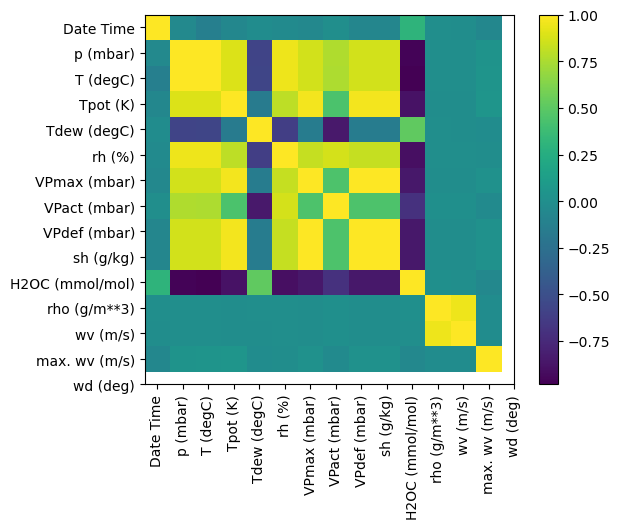

In [12]:
plt.imshow(corr)
_ = plt.xticks(ticks = np.arange(len(columns)), labels=columns, rotation=90)
_ = plt.yticks(ticks = np.arange(len(columns)), labels=columns)
plt.colorbar()
plt.show()

## Этап 1. OLS с нормированием, базовые метрики


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
target = "T (degC)"
excluded = ["Date Time", "p (mbar)",
               "T (degC)", "Tpot (K)",
               "Tdew (degC)"]
features = [c for c in dfh.columns if (c not in excluded)]

In [15]:
dates = [d.date() for d in dfh.index]

In [16]:
unique_dates = np.unique(dates)

In [17]:
dates_train, dates_test = train_test_split(unique_dates, test_size=0.7)

In [18]:
dfh_train = dfh[dfh.index.isin(dates_train)]

In [19]:
dfh_test = dfh[dfh.index.isin(dates_test)]

In [20]:
X_train, X_test = dfh_train[features], dfh_test[features]
y_train, y_test = dfh_train[target], dfh_test[target]

In [21]:
features

['rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

In [22]:
ols_pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
ols_pipe.fit(X_train, y_train)
y_pred_test = ols_pipe.predict(X_test)
y_pred_train = ols_pipe.predict(X_train)

In [23]:
# correct (daily) train-test split

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"OLS (normed) train: MAE={mae_test:.3f} | RMSE={rmse_test:.3f} | R²={r2_test:.3f}")
print(f"OLS (normed)  test: MAE={mae_train:.3f} | RMSE={rmse_train:.3f} | R²={r2_train:.3f}")

OLS (normed) train: MAE=0.407 | RMSE=0.572 | R²=0.994
OLS (normed)  test: MAE=0.405 | RMSE=0.559 | R²=0.994


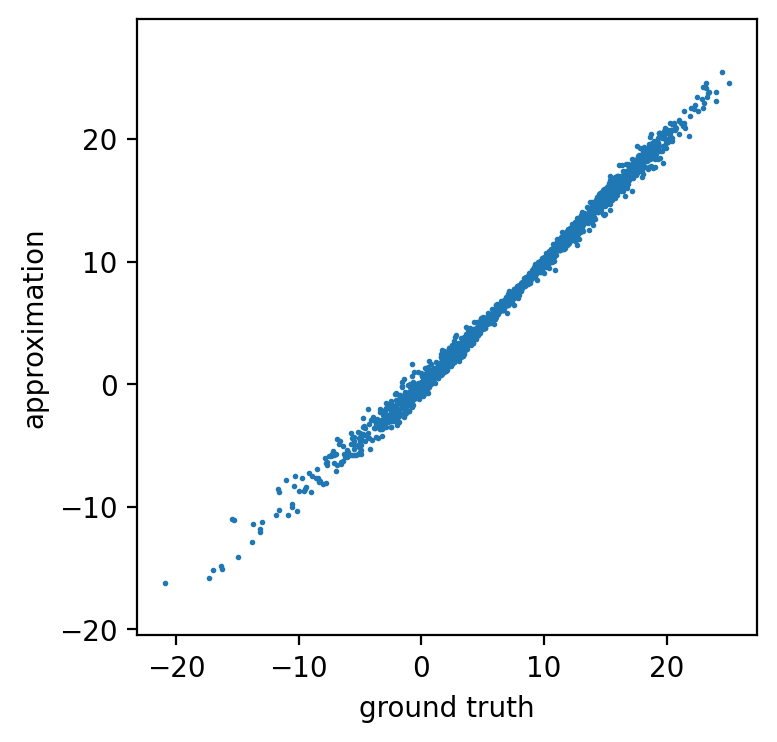

In [24]:
f = plt.figure(figsize=(4,4), dpi=200)
plt.scatter(y_test, y_pred_test, s=1)
plt.axis("equal")
# plt.xlim(-20, 50)
# plt.ylim(-20, 50)

plt.xlabel('ground truth')
plt.ylabel('approximation')
plt.show();

## Этап 2. Кросс-валидация по времени (TimeSeriesSplit) для OLS


In [25]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [26]:
tscv = TimeSeriesSplit(n_splits=5)
# Отрицательная MSE (чем ближе к 0 — тем лучше), и R² (чем выше — тем лучше)
cv_mse = cross_val_score(ols_pipe, X_train, y_train, cv=tscv, scoring="neg_mean_squared_error")
cv_r2  = cross_val_score(ols_pipe, X_train, y_train, cv=tscv, scoring="r2")

In [27]:
print("CV OLS (train):")
print("  RMSE по подвыборкам:", np.sqrt(-cv_mse))
print("  R² по подвыборкам:  ", cv_r2)
print("  Средний RMSE:", np.sqrt(-cv_mse).mean(), " | Средний R²:", cv_r2.mean())

CV OLS (train):
  RMSE по подвыборкам: [0.63341345 0.57056389 0.67836696 0.52782062 0.57099505]
  R² по подвыборкам:   [0.99179913 0.9948859  0.99094772 0.99278073 0.99271249]
  Средний RMSE: 0.596231993957513  | Средний R²: 0.9926251945596544


## Этап 3. Временные признаки + OLS с нормированием


In [28]:
work = dfh.copy()

In [29]:
ts = df[target].reset_index()
ts.columns = ["time", "value"]

In [30]:
ts.shape

(420551, 2)

In [64]:
ts_short = ts.iloc[:5000,:]

In [65]:
ts_short.head()

,time,value
0,2009-01-01 00:10:00,-8.02
1,2009-01-01 00:20:00,-8.41
2,2009-01-01 00:30:00,-8.51
3,2009-01-01 00:40:00,-8.31
4,2009-01-01 00:50:00,-8.27


In [66]:
df_lag, y_lag = make_forecasting_frame(ts_short["value"], kind="temp", max_timeshift=72, rolling_direction=1, )

Rolling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.78it/s]


In [67]:
df_lag.shape

(357372, 4)

In [92]:
df_lag.head()

,id,time,value,kind
1,"(id, 1)",0,-8.02,temp
3,"(id, 2)",0,-8.02,temp
4,"(id, 2)",1,-8.41,temp
6,"(id, 3)",0,-8.02,temp
7,"(id, 3)",1,-8.41,temp


In [68]:
y_lag.shape

(4999,)

In [69]:
features_lag = extract_features(df_lag, column_id="id", column_sort="time", column_value="value")

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:50<00:00,  5.69s/it]


In [93]:
X = features_lag.dropna(axis=1)

In [94]:
X = X.dropna(axis=0)

In [95]:
X.shape

(4999, 218)

In [125]:
y = y_lag.loc[X.index]

In [97]:
y.shape

(4999,)

In [99]:
weeks = [d.isocalendar().week for d in ts_short.time][1:]

In [113]:
X['week'] = weeks

In [126]:
y = pd.DataFrame(y, columns=['value'])

In [127]:
y.head()

,value
"(id, 1)",-8.41
"(id, 2)",-8.51
"(id, 3)",-8.31
"(id, 4)",-8.27
"(id, 5)",-8.05


In [128]:
y['week'] = weeks

In [130]:
y.head()

,value,week
"(id, 1)",-8.41,1
"(id, 2)",-8.51,1
"(id, 3)",-8.31,1
"(id, 4)",-8.27,1
"(id, 5)",-8.05,1


In [131]:
unique_weeks = np.unique(weeks)

In [132]:
unique_weeks

array([1, 2, 3, 4, 5, 6])

In [133]:
weeks_train, weeks_test = train_test_split(unique_weeks, train_size=0.7)

In [134]:
weeks_train, weeks_test

(array([1, 4, 2, 3]), array([5, 6]))

In [136]:
X_train = X[X.week.isin(weeks_train)]
X_train.shape

(3598, 219)

In [137]:
X_test = X[X.week.isin(weeks_test)]
X_test.shape

(1401, 219)

In [138]:
y_train = y[y.week.isin(weeks_train)]
y_train.shape

(3598, 2)

In [139]:
y_test = y[y.week.isin(weeks_test)]
y_test.shape

(1401, 2)

In [140]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [141]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f"Авторегрессия: RMSE={rmse:.3f}, MAE={mae:.3f}")

Авторегрессия: RMSE=0.359, MAE=0.103


In [ ]:
ols_lags_pipe = Pipeline([("scaler", StandardScaler()), ("ols", LinearRegression())])
ols_lags_pipe.fit(X2_train, y2_train)
y2_pred = ols_lags_pipe.predict(X2_test)

mae2 = mean_absolute_error(y2_test, y2_pred)
rmse2 = mean_squared_error(y2_test, y2_pred, squared=False)
r2_2 = r2_score(y2_test, y2_pred)
print(f"OLS (lags+roll, normed) — MAE={mae2:.3f} | RMSE={rmse2:.3f} | R²={r2_2:.3f}")

## Этап 4. Регуляризация: подбор `alpha` для Ridge и Lasso (GridSearchCV + TimeSeriesSplit)


In [ ]:
param_grid_ridge = {"ridge__alpha": np.logspace(-3, 3, 13)}
param_grid_lasso = {"lasso__alpha": np.logspace(-4, 1, 13)}

ridge_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(random_state=42))])
lasso_pipe = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(random_state=42, max_iter=10000))])

tscv = TimeSeriesSplit(n_splits=5)
gs_ridge = GridSearchCV(ridge_pipe, param_grid_ridge, scoring="neg_mean_squared_error", cv=tscv, n_jobs=None)
gs_lasso = GridSearchCV(lasso_pipe, param_grid_lasso, scoring="neg_mean_squared_error", cv=tscv, n_jobs=None)

gs_ridge.fit(X2_train, y2_train)
gs_lasso.fit(X2_train, y2_train)

best_ridge = gs_ridge.best_estimator_
best_lasso = gs_lasso.best_estimator_

print("Лучший alpha (Ridge):", gs_ridge.best_params_["ridge__alpha"])
print("Лучший alpha (Lasso):", gs_lasso.best_params_["lasso__alpha"])

ridge_pred = best_ridge.predict(X2_test)
lasso_pred = best_lasso.predict(X2_test)

ridge_rmse = mean_squared_error(y2_test, ridge_pred, squared=False)
lasso_rmse = mean_squared_error(y2_test, lasso_pred, squared=False)

ridge_mae = mean_absolute_error(y2_test, ridge_pred)
lasso_mae = mean_absolute_error(y2_test, lasso_pred)

ridge_r2 = r2_score(y2_test, ridge_pred)
lasso_r2 = r2_score(y2_test, lasso_pred)

print(f"Ridge*  (normed) — alpha={gs_ridge.best_params_['ridge__alpha']}, RMSE={ridge_rmse:.3f}, MAE={ridge_mae:.3f}, R²={ridge_r2:.3f}")
print(f"Lasso*  (normed) — alpha={gs_lasso.best_params_['lasso__alpha']}, RMSE={lasso_rmse:.3f}, MAE={lasso_mae:.3f}, R²={lasso_r2:.3f}")
